In [1]:
import os

os.chdir('/home/jinho93/tmdc/WTe2/mo-alloy/nonpolar/conf1/ps/md/more')

In [2]:
from pymatgen import Structure
from monty.serialization import loadfn

data = loadfn('data-w.json')
train_structures = [d['structure'] for d in data]
train_energies = [d['outputs']['energy'] for d in data]
train_forces = [d['outputs']['forces'] for d in data]

In [3]:
from maml.apps.pes import NNPotential
nnp = NNPotential()
nnp.train(train_structures=train_structures,
          train_energies=train_energies,
          train_forces=train_forces,
          # cutoff_type=1, atom_energy={'W': -3.0, 'Mo': -4.14, 'Te': -5.14},
          cutoff_type=1, atom_energy={'W': -3.0},
          r_etas = [0.5,1.0, 2.0], 
        #   a_etas = [0.5, 2.0, 4.0],
          r_shift=[0.0],
          # zetas=[1.0, 2.0, 4.0],
          r_cut=5, hidden_layers=[10, 10, 10], epochs=30)

0

In [12]:
from maml.apps.pes import EnergyForceStress
from pymatgen import Structure

# os.chdir('/home/jinho93/tmdc/WTe2/mo-alloy/nonpolar/conf1/ps/ph/large/w')
os.chdir('/home/jinho93/tmdc/WTe2/mo-alloy/nonpolar/lien/ph')
os.chdir('/home/jinho93/tmdc/WTe2/mo-alloy/nonpolar/lien/md/small/300/ph')

sets_of_forces = []
efs_calculator = EnergyForceStress(ff_settings=nnp)
efs_calculator.set_lmp_exe('/home/jinho93/Downloads/n2p2/bin/lmp_mpi')

for i in range(1, 73):
    print(i, end = '')
    struct = Structure.from_file(f'POSCAR-0{i:02d}')
    energy, forces, stresses = efs_calculator.calculate([struct])[0]
    sets_of_forces.append(forces)


INFO:maml.apps.pes._lammps:Setting Lammps executable to lmp_serial


123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172

In [13]:
from phonopy import Phonopy
import numpy as np

from phonopy.interface.calculator import read_crystal_structure
unitcell, _ = read_crystal_structure("POSCAR", interface_mode='vasp')

supc = np.reshape('4 0 0  0 8 0  0 0 1'.split(), (3, 3))
supc = supc.astype(float)
phonon = Phonopy(unitcell,
                 supc,
                #  primitive_matrix=np.reshape('0.0 0.5 0.5  0.5 0.0 0.5  0.5 0.5 0.0'.split(), (3, 3)))
                  primitive_matrix=np.identity(3))

In [14]:
sets_of_forces[0].shape

(384, 3)

In [15]:
phonon.generate_displacements()

phonon.set_forces(sets_of_forces)

phonon.produce_force_constants()

/home/jinho93/miniconda3/envs/mlph/lib/python3.7/site-packages/seekpath/hpkot/__init__.py:352: EdgeCaseWarning: aP lattice, but the k_alpha3 angle is almost equal to 90 degrees
  EdgeCaseWarning,
/home/jinho93/miniconda3/envs/mlph/lib/python3.7/site-packages/seekpath/hpkot/__init__.py:357: EdgeCaseWarning: aP lattice, but the k_beta3 angle is almost equal to 90 degrees
  EdgeCaseWarning,
/home/jinho93/miniconda3/envs/mlph/lib/python3.7/site-packages/seekpath/hpkot/__init__.py:362: EdgeCaseWarning: aP lattice, but the k_gamma3 angle is almost equal to 90 degrees
  EdgeCaseWarning,


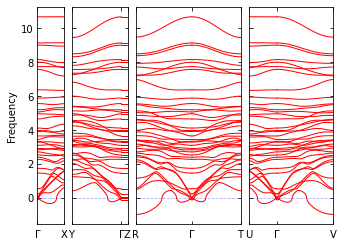

In [16]:
from phonopy.phonon.band_structure import get_band_qpoints
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections
# path = [[[0, 0, 0], [0, 0.5, 0.0], [0, 0, 0]],
        # [[0, 0, 0], [0.0, 0.0, 0.5], [0.5, 0.5, 0.5]]]
#labels = ["$\\Gamma$", "X", "M", "M", "$\\Gamma$", "R", "M"]
# qpoints, connections = get_band_qpoints_and_path_connections(path, npoints=51)
# phonon.run_band_structure(qpoints, path_connections=connections, labels=labels, with_eigenvectors=True)

phonon.auto_band_structure(plot=True, with_eigenvectors=True).show()

In [20]:
phonon.write_animation([0.5, 0.5, 0.5])

'anime.ascii'